# Librerie


In [28]:
import os
import pandas as pd
import subprocess
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Dataset


In [16]:
# Leggi il file JSON e caricalo in un dataframe
df = pd.read_json('df_test.json')

# Stampa la testa del dataframe
print(df.head())

                                        _id  \
24286  {'$oid': '6527b17999826ba7e58ebd4c'}   
24372  {'$oid': '6527b2c499826ba7e592f60d'}   
24726  {'$oid': '6527b1ea99826ba7e5900fe3'}   
24716  {'$oid': '6527b2b199826ba7e592ab24'}   
25001  {'$oid': '6527b18899826ba7e58edae0'}   

                                                    func  target  \
24286  std::string get_wml_location(const std::string...       1   
24372  Status RunRestore(const RunOptions& run_option...       0   
24726  gdIOCtx * gdNewDynamicCtxEx (int initialSize, ...       0   
24716  void gf_filter_check_output_reconfig(GF_Filter...       0   
25001  RoleName RoleName::parseFromBSON(const BSONEle...       1   

                     cwe     project  size  
24286          [CWE-200]     wesnoth    60  
24372  [CWE-20, CWE-703]  tensorflow    36  
24726          [CWE-119]     php-src    24  
24716          [CWE-787]        gpac    33  
25001           [CWE-20]       mongo    20  


In [17]:
# Funzione per creare i file C
def create_c_files_from_dataframe(df, directory):
    # Crea la directory se non esiste
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Itera su ogni riga del dataframe
    for index, row in df.iterrows():
        # Estrai l'ID e il contenuto della funzione
        file_id = row['_id']['$oid']
        func_content = row['func']
        
        # Definisci il nome del file
        file_name = f"{file_id}.c"
        file_path = os.path.join(directory, file_name)
        
        # Scrivi il contenuto della funzione nel file
        with open(file_path, 'w') as file:
            file.write(func_content)

# Definisci il percorso della cartella di destinazione
output_directory = 'funzioni_c'

# Crea i file C
create_c_files_from_dataframe(df, output_directory)


# clang


# Flawfinder


In [18]:
# Definisci il comando e i suoi argomenti come una lista
command = ["flawfinder", "funzioni_c/"]

# Esegui il comando e cattura l'output
result = subprocess.run(command, capture_output=True, text=True)

# Scrivi l'output su un file
with open("report_flawfinder.txt", "w") as file:
    file.write(result.stdout)

# Stampa eventuali errori
if result.stderr:
    print(result.stderr)

In [19]:
# Definisci il comando e i suoi argomenti come una lista
command = ["flawfinder", "-F", "funzioni_c/"]

# Esegui il comando e cattura l'output
result = subprocess.run(command, capture_output=True, text=True)

# Scrivi l'output su un file
with open("report_flawfinder_noFP.txt", "w") as file:
    file.write(result.stdout)

# Stampa eventuali errori
if result.stderr:
    print(result.stderr)

In [20]:
def conta_occorrenze(nome_file, nome_func):
    with open(nome_file, 'r') as file:
        # Leggi il contenuto del file
        content = file.read()
        # Conta le occorrenze del nome_func nel contenuto del file
        count = content.count(nome_func)
    return count

# Definisci il percorso della cartella contenente i file .c
cartella = "funzioni_c"

# Ottieni una lista di tutti i file .c nella cartella
files = [file for file in os.listdir(cartella) if file.endswith(".c")]

# Crea il dataframe
dv = pd.DataFrame({"nome_func": files})

# Specifica il percorso del file di testo in cui contare le occorrenze
percorso_file_testo = "report_flawfinder.txt"

# Popola la colonna ausiliaria "count" contando le occorrenze di ogni nome_func nel file di testo
dv['count'] = dv['nome_func'].apply(lambda x: conta_occorrenze(percorso_file_testo, x))

dv['target'] = dv['count'].apply(lambda x: 1 if x > 1 else 0)

# Stampa il numero totale di voci nel dataframe
print("Numero totale di voci nel dataframe:", dv.shape[0])

# Verifica se la colonna count contiene almeno un valore pari a 0
if (dv['count'] == 0).any():
    print("La colonna 'count' contiene almeno un valore pari a 0.")
else:
    print("La colonna 'count' non contiene valori pari a 0.")

# Elimina la colonna ausiliaria count
dv.drop(columns=['count'], inplace=True)

# Stampa il dataframe
print(dv)

Numero totale di voci nel dataframe: 1254
La colonna 'count' non contiene valori pari a 0.
                       nome_func  target
0     6527b17999826ba7e58ebd4e.c       0
1     6527b18d99826ba7e58ee366.c       0
2     6527b2b499826ba7e592b6e9.c       0
3     6527b17a99826ba7e58ec1c1.c       1
4     6527b2c899826ba7e592ffea.c       1
...                          ...     ...
1249  6527b22f99826ba7e590e682.c       0
1250  6527b2f699826ba7e593aaea.c       0
1251  6527b2a599826ba7e59278a8.c       0
1252  6527b18699826ba7e58ed4ae.c       0
1253  6527b27799826ba7e591dd11.c       0

[1254 rows x 2 columns]


Conteggio dei valori target:
target
0    1087
1     167
Name: count, dtype: int64


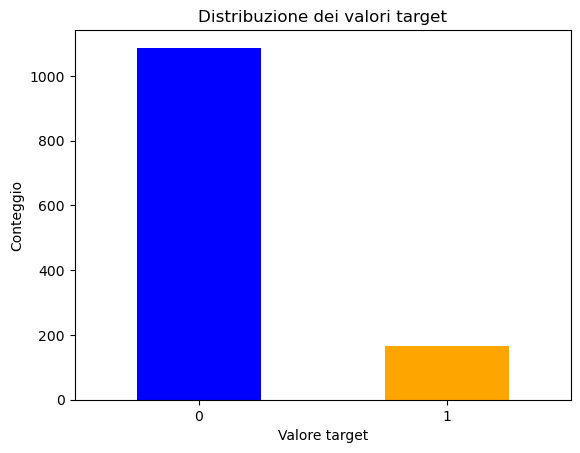

In [21]:
# Conta quanti valori target sono pari a 0 e 1
count_target = dv['target'].value_counts()

# Stampa il conteggio
print("Conteggio dei valori target:")
print(count_target)

# Plot della distribuzione dei valori target
count_target.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribuzione dei valori target')
plt.xlabel('Valore target')
plt.ylabel('Conteggio')
plt.xticks([0, 1], ['0', '1'], rotation=0)
plt.show()


# Creazione vettore predizioni flawfinder


In [22]:
df.drop(['cwe','project','size', 'func'], axis='columns', inplace=True)


In [23]:
# Funzione per estrarre l'identificativo
def extract_oid(oid_dict):
    return oid_dict['$oid']

# Applicare la funzione a ogni riga del DataFrame
df['_id'] = df['_id'].apply(extract_oid)
df.head()

,_id,target
24286,6527b17999826ba7e58ebd4c,1
24372,6527b2c499826ba7e592f60d,0
24726,6527b1ea99826ba7e5900fe3,0
24716,6527b2b199826ba7e592ab24,0
25001,6527b18899826ba7e58edae0,1


In [24]:
df.reset_index(drop=True, inplace=True)
df.head()

,_id,target
0,6527b17999826ba7e58ebd4c,1
1,6527b2c499826ba7e592f60d,0
2,6527b1ea99826ba7e5900fe3,0
3,6527b2b199826ba7e592ab24,0
4,6527b18899826ba7e58edae0,1


In [25]:
# Rimuovere il suffisso .c dalla colonna nome_func
dv['nome_func'] = dv['nome_func'].str.replace('.c', '', regex=False)
dv.head()

,nome_func,target
0,6527b17999826ba7e58ebd4e,0
1,6527b18d99826ba7e58ee366,0
2,6527b2b499826ba7e592b6e9,0
3,6527b17a99826ba7e58ec1c1,1
4,6527b2c899826ba7e592ffea,1


In [26]:
# Ordina dv in base all'ordine della colonna nome_func di df
dv['sort_index'] = dv['nome_func'].apply(lambda x: df[df['_id'] == x].index[0])
dv.sort_values(by='sort_index', inplace=True)

# Rimuove la colonna sort_index usata per l'ordinamento
dv.drop(columns='sort_index', inplace=True)

print(df)
print(dv)

                           _id  target
0     6527b17999826ba7e58ebd4c       1
1     6527b2c499826ba7e592f60d       0
2     6527b1ea99826ba7e5900fe3       0
3     6527b2b199826ba7e592ab24       0
4     6527b18899826ba7e58edae0       1
...                        ...     ...
1249  6527b17999826ba7e58ebdff       1
1250  6527b1e199826ba7e58ff171       0
1251  6527b2b099826ba7e592a5fb       0
1252  6527b18399826ba7e58ed3e9       1
1253  6527b17999826ba7e58ebfee       1

[1254 rows x 2 columns]
                     nome_func  target
701   6527b17999826ba7e58ebd4c       0
960   6527b2c499826ba7e592f60d       0
1016  6527b1ea99826ba7e5900fe3       0
790   6527b2b199826ba7e592ab24       0
904   6527b18899826ba7e58edae0       0
...                        ...     ...
470   6527b17999826ba7e58ebdff       0
699   6527b1e199826ba7e58ff171       0
990   6527b2b099826ba7e592a5fb       0
585   6527b18399826ba7e58ed3e9       0
1054  6527b17999826ba7e58ebfee       0

[1254 rows x 2 columns]


Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.90      0.66       627
           1       0.61      0.16      0.26       627

    accuracy                           0.53      1254
   macro avg       0.56      0.53      0.46      1254
weighted avg       0.56      0.53      0.46      1254



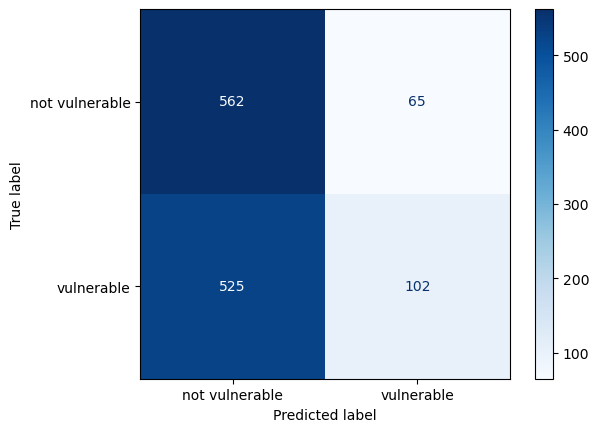

In [29]:
true_labels = df['target'].values
predicted_labels = dv['target'].values

# Step 11: Stampa del classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

target_names = ['not vulnerable', 'vulnerable']

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizza la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [30]:
# Salva dv come un file JSON
dv.to_json('flawfinder_prediction.json', orient='records', lines=True)

In [33]:
# Salva dv come un file JSON
df.to_json('df_test.json', orient='records', lines=True)